run this on google collab

In [ ]:
# general imports
import yfinance as yf
import pandas as pd

In [ ]:
# imports for model
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

## Data


### Loading in Data

In [ ]:
# reminder to upload the data file to collab
btc_cmc_data = pd.read_csv("bitcoin_prices_2016010120241121.csv", delimiter=";")
print(btc_cmc_data.columns)

Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'timestamp'],
      dtype='object')


In [ ]:
# YFINANCE
# create a ticker object, then get history
btc_tk = yf.Ticker("BTC-USD")
btc_all_data = btc_tk.history(period="max")

btc_f_tk = yf.Ticker("BTC=F")
btc_futures_all_data = btc_f_tk.history(period="max")

vix_tk = yf.Ticker("^VIX")
vix_all_data = vix_tk.history(period="max")

In [ ]:
# Kaggle data
btc_hourly = pd.read_csv("kaggle_btc_hourly.csv") # 2018-05-16 -> 2022-03-01
btc_tweets_smallest = pd.read_pickle('btc_tweets_smallest.pkl')

In [ ]:
# # one time code
# btc_tweets_large = pd.read_csv("Bitcoin_tweets.csv", engine='python')
# btc_tweets_small = btc_tweets_large[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_small.to_pickle('btc_tweets_small.pkl')

# btc_tweets_smallest = pd.read_csv("Bitcoin_tweets_dataset_2.csv", engine='python')
# btc_tweets_smallest = btc_tweets_smallest[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_smallest.to_pickle('btc_tweets_smallest.pkl')

# btc_tweets_smallest.to_pickle('~/btc_tweets_smallest.pkl')

In [ ]:
btc_tweets_smallest.head()

,user_followers,user_verified,date,text,hashtags,source,is_retweet
0,4680.0,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False
1,770.0,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False
2,576.0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False
3,236.0,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False
4,12731.0,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False


### Cleaning Data

In [ ]:
def clean_data(data, start="2020-01-01", end=None):
    # filter with and start and end
    if start:
        data = data[data.index >= start]
    if end:
        data = data[data.index <= end]

    # check number of NA rows
    print(f"{data.isna().any(axis=1).sum()} / {len(data)} has NA in the row" )

    return data

In [ ]:
btc_all_data = clean_data(btc_all_data)
vix_all_data =  clean_data(vix_all_data)

0 / 1789 has NA in the row
0 / 1233 has NA in the row


In [ ]:
# btc_all_data.to_pickle('btc_all_data_2020.pkl')

In [ ]:
btc_all_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0


In [ ]:
btc_hourly = btc_hourly.sort_values(by='date', ascending=True)
btc_hourly.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
33258,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
33257,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
33256,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
33255,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
33254,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


### CNN-LSTM Model


#### Setting up data for model inputs
* figure out how to train it on multiple columns?

,open,high,low,close,volume
Date,,,,,
2024-11-19 00:00:00+00:00,90536.812500,94002.867188,90426.984375,92343.789062,74521048295
2024-11-20 00:00:00+00:00,92341.890625,94902.023438,91619.500000,94339.492188,71730956426
2024-11-21 00:00:00+00:00,94334.640625,99014.218750,94132.601562,98504.726562,106024505582
2024-11-22 00:00:00+00:00,98496.429688,99655.500000,97222.664062,98997.664062,78473580551
2024-11-23 00:00:00+00:00,99005.304688,99005.304688,98360.640625,98607.515625,60167045120


In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler

# https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

all_data = btc_hourly[["unix", "open", "high", "low", "close", "Volume BTC"]] # hourly data
all_data = btc_all_data[["Open", "High", "Low", "Close", "Volume"]] # daily data - date is the index
all_data.columns = all_data.columns.str.lower()

training_col = "close"

# split into training and testing data (no validaiton set)
training_data_len = math.ceil(len(all_data) * .8)
train_data = all_data[:training_data_len].iloc[:, :]
test_data = all_data[training_data_len:].iloc[:, :]

def column_setup(col_name, data):
    dataset = data[col_name].values
    dataset = np.reshape(dataset, (-1, 1))
    print(dataset.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_dataset = scaler.fit_transform(dataset)
    print(scaled_dataset[:5])

    return scaled_dataset

scaled_train = column_setup(training_col, train_data)
scaled_test =column_setup(training_col, test_data)

# # selecting open price values
# dataset_train = train_data["close"].values
# # reshaping 1D to 2D array
# dataset_train = np.reshape(dataset_train, (-1, 1))
# print(dataset_train.shape)

# # Selecting Open Price values
# dataset_test = test_data["close"].values
# # Reshaping 1D to 2D array
# dataset_test = np.reshape(dataset_test, (-1, 1))
# print(dataset_test.shape)

# scaler = MinMaxScaler(feature_range=(0, 1))
# # scaling dataset
# scaled_train = scaler.fit_transform(dataset_train)
# print(scaled_train[:5])

# # normalizing values between 0 and 1
# scaled_test = scaler.fit_transform(dataset_test)
# print(scaled_test[:5])

sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# create sequences and labels for testing data
sequence_length = 30  # number of time steps to look back. ... do these need to be the same length
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

(1432, 1)
[[0.03561545]
 [0.03218546]
 [0.03792726]
 [0.038978  ]
 [0.03898856]]
(357, 1)
[[0.00791765]
 [0.04156527]
 [0.07687441]
 [0.07125663]
 [0.06362881]]
torch.Size([1382, 50, 1]) torch.Size([1382, 1])
torch.Size([327, 30, 1]) torch.Size([327, 1])


#### Architecture

Follow a CNN-LSTM approach

Model Architecture
  1. CNN
  2. Max pooling
  3. LSTM
  4. Dropout
  5. LSTM
  6. Dropout
  7. Dense
  8. Dense

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [ ]:
import torch
import torch.nn as nn

class BTCPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, dropout_rate=0.2):
        super(BTCPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        # Adjust CNN to handle `n_features` input channels (e.g., 5 for OHLCV data)
        self.c1 = nn.Conv1d(in_channels=n_features, out_channels=n_features, kernel_size=2, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # LSTM layers with `input_size=n_features`
        self.lstm1 = nn.LSTM(
            input_size=n_features,  # Match number of features in each time step
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(
            input_size=n_hidden,  # Output from LSTM 1 feeds to LSTM 2
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout2 = nn.Dropout(dropout_rate)

        # Final linear layers
        self.linear1 = nn.Linear(in_features=n_hidden, out_features=1)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=1)

    def forward(self, sequences):
        # Expecting `sequences` to be (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = sequences.size()

        # Permute to match Conv1D expected input: (batch_size, n_features, seq_len)
        x = sequences.permute(0, 2, 1)
        x = self.c1(x)  # Apply Conv1D; shape becomes (batch_size, n_features, new_seq_len)
        x = self.maxpool(x)  # Apply MaxPool; shape becomes (batch_size, n_features, pooled_seq_len)

        # Permute to match LSTM expected input: (pooled_seq_len, batch_size, n_features)
        x = x.permute(2, 0, 1)

        # Initialize hidden state with dynamic batch size
        device = x.device
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device),
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        )

        # Pass through LSTM layers
        lstm_out1, _ = self.lstm1(x, hidden)
        lstm_out1 = self.dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # Use the last time step's output for prediction
        last_time_step = lstm_out2[-1, :, :]

        # Linear layers for final prediction
        y_pred1 = self.linear1(last_time_step)
        y_pred2 = self.linear2(last_time_step)

        # Combine predictions
        y_pred = y_pred1 + y_pred2

        return y_pred


In [ ]:
# Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 24  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cuda
Epoch [10/100] - Training Loss: 0.0049, Test Loss: 0.0105
Epoch [20/100] - Training Loss: 0.0022, Test Loss: 0.0053
Epoch [30/100] - Training Loss: 0.0018, Test Loss: 0.0038
Epoch [40/100] - Training Loss: 0.0017, Test Loss: 0.0033
Epoch [50/100] - Training Loss: 0.0018, Test Loss: 0.0035
Epoch [60/100] - Training Loss: 0.0014, Test Loss: 0.0034
Epoch [70/100] - Training Loss: 0.0017, Test Loss: 0.0031
Epoch [80/100] - Training Loss: 0.0013, Test Loss: 0.0034
Epoch [90/100] - Training Loss: 0.0013, Test Loss: 0.0032
Epoch [100/100] - Training Loss: 0.0013, Test Loss: 0.0035


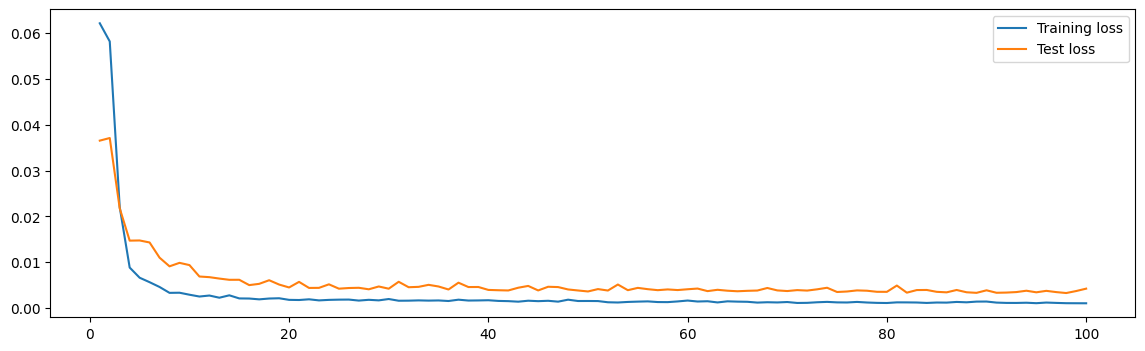

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

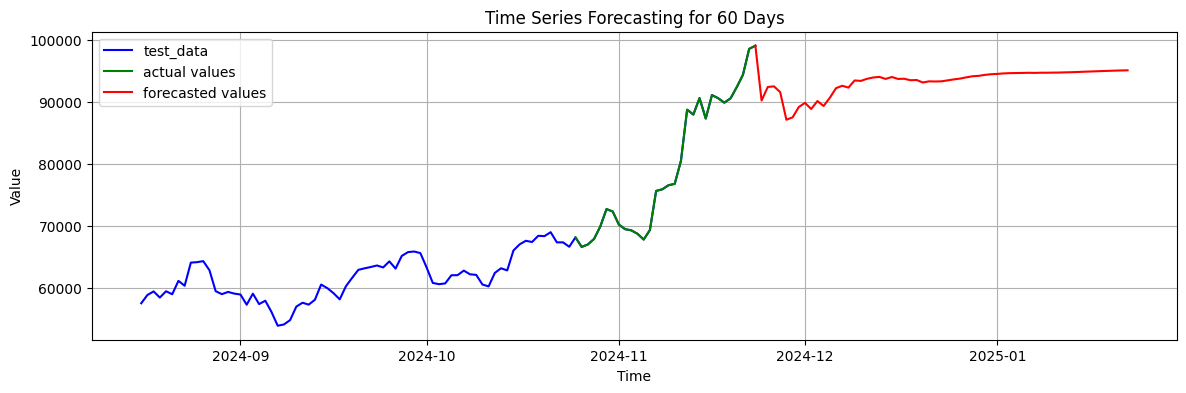

RMSE: 0.0557
R² Score: 0.8979


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction period in days (can also be set to weeks or months by changing the frequency)
prediction_period = 60  # Specify the number of days, e.g., 60 days for two months
num_forecast_steps = prediction_period

# Prepare historical data for prediction
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare historical data as input to the model
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Convert the last date in the test dataset to datetime format
last_unix_timestamp = test_data.index[-1]
last_date = pd.to_datetime(last_unix_timestamp, unit='s')

# Generate future dates based on the specified prediction period and daily frequency
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=num_forecast_steps, freq='D')

# Plot the historical and forecasted values
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(pd.to_datetime(test_data.index[-100:], unit='s'), test_data['open'].values[-100:], label="test_data", color="b")
plt.plot(pd.to_datetime(test_data.index[-30:], unit='s'), test_data['open'].values[-30:], label='actual values', color='green')

# Concatenate forecasted values and plot
forecasted_series = np.concatenate([test_data["open"].values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])
plt.plot(pd.to_datetime(test_data.index[-1:], unit='s').append(future_dates), forecasted_series, label='forecasted values', color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title(f'Time Series Forecasting for {prediction_period} Days')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


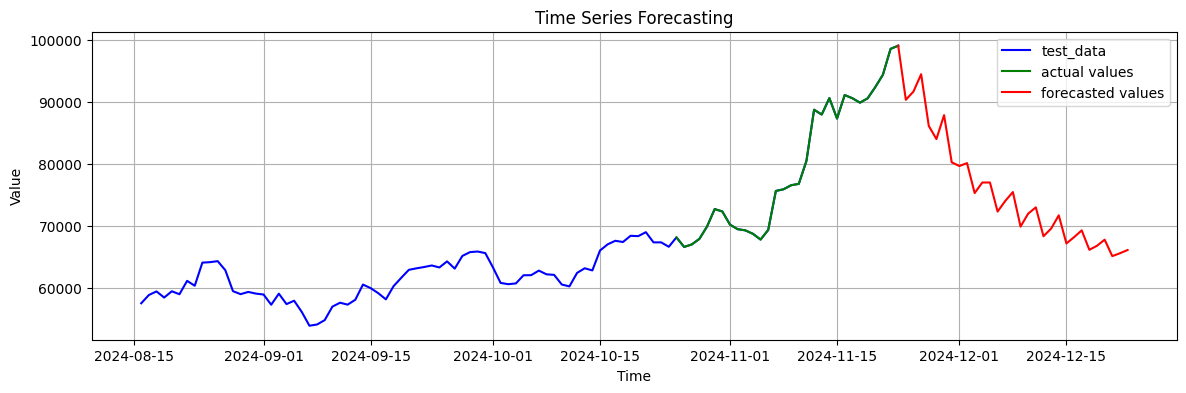

RMSE: 0.0618
R² Score: 0.8745


In [ ]:
# prediction of daily model

# Assume `device` is already defined (e.g., `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`)
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Convert the last date from Unix timestamp to datetime
last_unix_timestamp = test_data.index[-1]
last_date = pd.to_datetime(last_unix_timestamp, unit='s')

future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=num_forecast_steps, freq='D')

# Plot the historical and forecasted values
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(pd.to_datetime(test_data.index[-100:], unit='s'), test_data['open'].values[-100:], label="test_data", color="b")
plt.plot(pd.to_datetime(test_data.index[-30:], unit='s'), test_data['open'].values[-30:], label='actual values', color='green')

# Concatenate forecasted values and plot
forecasted_series = np.concatenate([test_data["open"].values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])
plt.plot(pd.to_datetime(test_data.index[-1:], unit='s').append(future_dates), forecasted_series, label='forecasted values', color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


In [ ]:
forecasted_series
# future_dates

array([ 99005.3046875,  95827.6875   ,  96353.3046875,  96781.609375 ,
        95617.7265625,  95257.28125  ,  95132.453125 ,  94931.7109375,
        95668.78125  ,  96056.609375 ,  96962.6328125,  97627.5078125,
        98524.0234375,  99263.625    ,  99972.234375 , 100659.8203125,
       101176.2109375, 101714.984375 , 102016.       , 102452.2109375,
       102610.0703125, 102950.7578125, 103013.640625 , 103257.5625   ,
       103288.84375  , 103409.171875 , 103467.7578125, 103510.5390625,
       103652.0390625, 103733.8515625, 103942.4921875])

<Axes: xlabel='Date'>

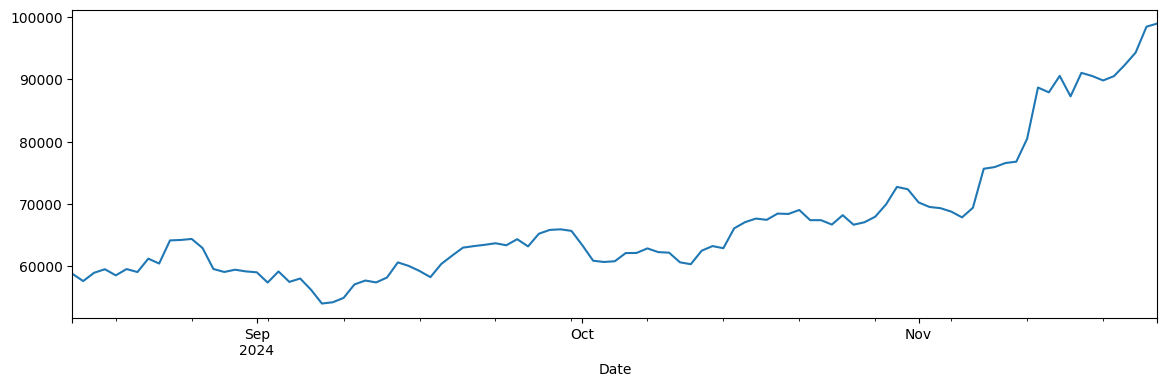

In [ ]:
btc_all_data_filtered = btc_all_data[btc_all_data.index >= '2024-08-15']
# Plot the "Open" column starting from 2024-08-01
btc_all_data_filtered["Open"].plot()

In [ ]:
torch.save(model.state_dict(), "./model_daily.pt")

### Backtesting